# Leitura dos Dados

Inicialmente iremos realizar a leitura dos dados que serão utilizados para pergunta e resposta. Estamos considerando como other a intenção de Q&A.

In [209]:
import numpy as np
import pandas as pd

In [210]:
qa_data = pd.read_csv("q&a_intent_train.csv", names= ["target", "text"])

qa_data

,target,text
0,other,What is the principle behind flight?
1,other,What are the four forces acting on an airplane?
2,other,What is the difference between IFR and VFR?
3,other,What is a black box in aviation?
4,other,What is the busiest airport in the world by pa...
...,...,...
94,other,"What is ""ACARS""?"
95,other,"What is ""Alternate Airport""?"
96,other,"at does ""pan-pan"" mean?"
97,other,"What is ""decision height"" (DH)?"


Leitura dos dados de treino e teste disponibilizados pelo ATIS dataset.

In [211]:
atis_train_data = pd.read_csv("atis_intents_train.csv", names= ["target", "text"])
atis_test_data = pd.read_csv("atis_intents_test.csv", names= ["target", "text"])

print("ATIS train dataset size is:", len(atis_train_data))
print("ATIS test dataset size is:", len(atis_test_data))

ATIS train dataset size is: 4834
ATIS test dataset size is: 800


Iremos construir um dataset para treino e teste considerando os dados que temos até então. Para tanto, separaremos qa_data em treino e teste (considerando por volta de 20% para teste) e depois construíremos um dataset para treino e um para teste unindo as tabelas até então existentes.

In [212]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
qa_train_data, qa_test_data = train_test_split(qa_data, test_size=0.20, random_state=42)

print("Q&A train dataset size is:", len(qa_train_data))
print("Q&A test dataset size is:", len(qa_test_data))

Q&A train dataset size is: 79
Q&A test dataset size is: 20


In [213]:
train_data = pd.concat([qa_train_data, atis_train_data], ignore_index=True)

train_data

,target,text
0,other,"What is a ""taxiway""?"
1,other,"What is a ""slot-restricted"" airport?"
2,other,"What is ""NextGen"" in U.S. aviation?"
3,other,"What does the term ""gate hold"" mean in aviation?"
4,other,"What does ""direct flight"" mean as opposed to ""..."
...,...,...
4908,atis_airfare,what is the airfare for flights from denver t...
4909,atis_flight,do you have any flights from denver to baltim...
4910,atis_airline,which airlines fly into and out of denver
4911,atis_flight,does continental fly from boston to san franc...


In [214]:
test_data = pd.concat([qa_test_data, atis_test_data], ignore_index=True)

test_data

,target,text
0,other,"What is ""yaw"" in aviation?"
1,other,"What is a ""deadhead"" flight?"
2,other,"What is ""Alternate Airport""?"
3,other,What is the purpose of ailerons on an aircraft?
4,other,"What is ""decision height"" (DH)?"
...,...,...
815,atis_flight,please find all the flights from cincinnati t...
816,atis_flight,find me a flight from cincinnati to any airpo...
817,atis_flight,i'd like to fly from miami to chicago on amer...
818,atis_flight,i would like to book a round trip flight from...


# SVM

## Bag of Words

In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train_data["text"])

TfidfVectorizer()

In [216]:
X_train = tfidf_vectorizer.transform(train_data["text"])

X_train

<4913x964 sparse matrix of type '<class 'numpy.float64'>'
	with 51273 stored elements in Compressed Sparse Row format>

In [217]:
X_test = tfidf_vectorizer.transform(test_data["text"])

X_test

<820x964 sparse matrix of type '<class 'numpy.float64'>'
	with 7766 stored elements in Compressed Sparse Row format>

## SVM Classifier

### Define and Train the SVM Classifier

In [218]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier using the BoW features from the training data
svm_classifier.fit(X_train, train_data['target'])

SVC(kernel='linear', random_state=42)

### Predict on the Test Data and Evaluate the Model

In [219]:
# Predict the target values for the test data
y_test_pred = svm_classifier.predict(X_test)

# Evaluate the predictions against the actual target values from the test data
print("Accuracy on test data:", accuracy_score(test_data['target'], y_test_pred))
print("\nClassification Report on test data:\n", classification_report(test_data['target'], y_test_pred))

Accuracy on test data: 0.975609756097561

Classification Report on test data:
                      precision    recall  f1-score   support

  atis_abbreviation       0.89      1.00      0.94        33
      atis_aircraft       0.67      0.89      0.76         9
       atis_airfare       0.96      0.98      0.97        48
       atis_airline       1.00      0.92      0.96        38
        atis_flight       0.99      0.98      0.99       632
   atis_flight_time       1.00      1.00      1.00         1
atis_ground_service       1.00      1.00      1.00        36
      atis_quantity       0.38      1.00      0.55         3
              other       1.00      0.75      0.86        20

           accuracy                           0.98       820
          macro avg       0.88      0.95      0.89       820
       weighted avg       0.98      0.98      0.98       820



In [220]:
def predict_intention(text):
    # Preprocess the text using spaCy or any other preprocessing steps you have
    preprocessed_text = preprocess_text(text)  # Assuming preprocess_text is your custom preprocessing function
    
    # Transform the preprocessed text into BoW format using the same vectorizer
    text_bow = vectorizer.transform([preprocessed_text])
    
    # Predict the intention using the trained SVM classifier
    predicted_intention = svm_classifier.predict(text_bow)
    
    # Return the predicted intention
    return predicted_intention[0]

# Example usage
example_text = "What are the four forces acting on an airplane?"
predicted_intention = predict_intention(example_text)
print(f"The predicted intention for '{example_text}' is '{predicted_intention}'.")


The predicted intention for 'What are the four forces acting on an airplane?' is 'atis_aircraft'.


# Word Embeddings

## Tokenization

In [221]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [222]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["text"])

In [223]:
WORD_INDEX = tokenizer.word_index
MAX_VOCAB_SIZE = len(WORD_INDEX) + 1

In [224]:
# Get the maximum length of a sequence in the training data or test data
max_seq_length_train = max([len(seq.split()) for seq in train_data["text"]])
max_seq_length_test = max([len(seq.split()) for seq in test_data["text"]])
INPUT_LENGTH = max(max_seq_length_train, max_seq_length_test)

In [225]:
train_data_tokens = tokenizer.texts_to_sequences(train_data["text"])
padded_train_data = pad_sequences(train_data_tokens, maxlen=INPUT_LENGTH)

In [226]:
test_data_tokens = tokenizer.texts_to_sequences(test_data["text"])
padded_test_data = pad_sequences(test_data_tokens, maxlen=INPUT_LENGTH)

## Encode the Labels

In [227]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_data["target"])

LabelEncoder()

In [228]:
encoded_train_labels = label_encoder.transform(train_data["target"])
encoded_test_labels = label_encoder.transform(test_data["target"])

In [229]:
# One-hot encoding the labels
encoded_train_labels = to_categorical(np.asarray(encoded_train_labels))
encoded_test_labels = to_categorical(np.asarray(encoded_test_labels))

In [230]:
# X_train: The subsert of `padded_train_data` that will be used for training the model.
# X_test: The subset of `padded_train_data` that will be used for validating the model.
# y_train: The subset of `encoded_train_labels` that corresponds to `X_train`, to be used as the target labels for training the model.
# y_test: The subset of `encoded_train_labels` that corresponds to `X_test`, to be used as the target labels for validating the model.

X_train, X_test, y_train, y_test  = train_test_split(padded_train_data, encoded_train_labels, test_size=0.2, random_state=1)

## Create Embedding Matrix

In [231]:
embedded_dim = 300
embedded_index = dict()

with open ('glove.42B.300d.txt','r',encoding='utf8') as glove : 
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedded_index[word] = vector

embedded_matrix = np.zeros((MAX_VOCAB_SIZE, embedded_dim))

for x , i in WORD_INDEX.items():
    vector = embedded_index.get(x)
    if vector is not None:
        embedded_matrix[i] = vector

# CNN

In [232]:
from keras.layers import Flatten, Conv1D, MaxPooling1D
from keras.layers import Dense
from keras.models import Sequential

In [233]:
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, 300, input_length= INPUT_LENGTH, weights=[embedded_matrix], trainable=False))
model.add(Conv1D(filters=32, kernel_size=9, activation='selu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='selu'))
model.add(Dense(9, activation='sigmoid'))

In [234]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 46, 300)           300600    
                                                                 
 conv1d_6 (Conv1D)           (None, 38, 32)            86432     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 608)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                6090      
                                                                 
 dense_11 (Dense)            (None, 9)                 99        
                                                      

In [268]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=60, verbose=2, validation_data=(X_test, y_test))

Epoch 1/60
123/123 - 1s - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.2812 - val_accuracy: 0.9613 - 776ms/epoch - 6ms/step
Epoch 2/60
123/123 - 1s - loss: 7.4008e-04 - accuracy: 0.9997 - val_loss: 0.3010 - val_accuracy: 0.9563 - 557ms/epoch - 5ms/step
Epoch 3/60
123/123 - 1s - loss: 2.1103e-04 - accuracy: 1.0000 - val_loss: 0.2289 - val_accuracy: 0.9664 - 555ms/epoch - 5ms/step
Epoch 4/60
123/123 - 1s - loss: 1.6591e-05 - accuracy: 1.0000 - val_loss: 0.2355 - val_accuracy: 0.9664 - 553ms/epoch - 4ms/step
Epoch 5/60
123/123 - 1s - loss: 1.2825e-05 - accuracy: 1.0000 - val_loss: 0.2351 - val_accuracy: 0.9644 - 551ms/epoch - 4ms/step
Epoch 6/60
123/123 - 1s - loss: 1.1201e-05 - accuracy: 1.0000 - val_loss: 0.2360 - val_accuracy: 0.9634 - 547ms/epoch - 4ms/step
Epoch 7/60
123/123 - 1s - loss: 1.0096e-05 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9644 - 550ms/epoch - 4ms/step
Epoch 8/60
123/123 - 1s - loss: 9.2587e-06 - accuracy: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.96

In [288]:
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

predictions = model.predict(padded_test_data)
print(acc(encoded_test_labels, predictions))

26/26 [==============================] - 0s 2ms/step
0.9768292682926829


In [289]:
# Create a classification report for the model's predictions
from sklearn.metrics import classification_report

# Convert the one-hot encoded test labels back to categorical labels
y_test_labels = np.argmax(encoded_test_labels, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

# Generate the classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))


                     precision    recall  f1-score   support

  atis_abbreviation       0.89      0.97      0.93        33
      atis_aircraft       1.00      0.67      0.80         9
       atis_airfare       0.96      0.94      0.95        48
       atis_airline       0.95      0.95      0.95        38
        atis_flight       0.99      0.99      0.99       632
   atis_flight_time       1.00      1.00      1.00         1
atis_ground_service       0.97      1.00      0.99        36
      atis_quantity       0.50      1.00      0.67         3
              other       0.88      0.75      0.81        20

           accuracy                           0.98       820
          macro avg       0.90      0.92      0.90       820
       weighted avg       0.98      0.98      0.98       820



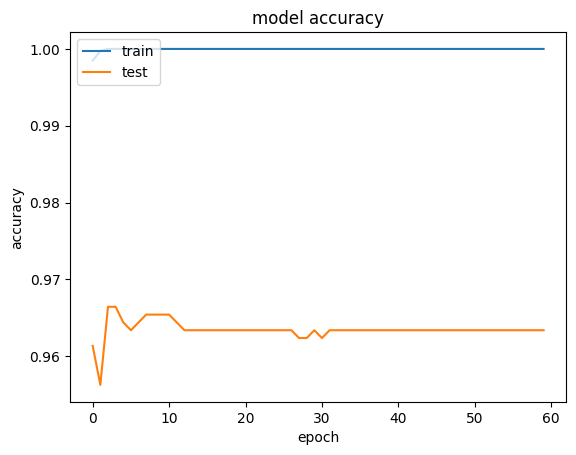

In [270]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

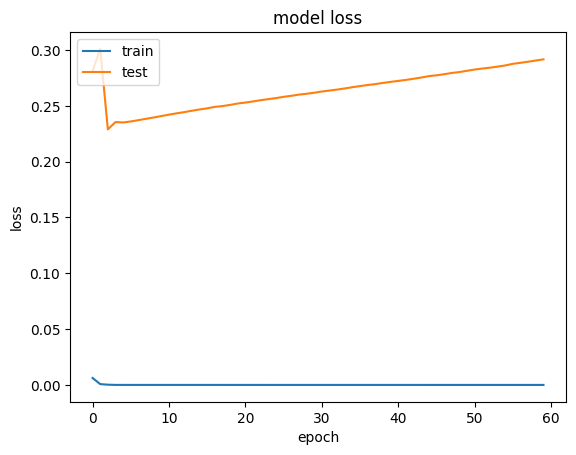

In [271]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()